In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter
from GCRCatalogs import GCRQuery

In [3]:
truth_quantities = ['cosmodc2_id', 'ra', 'dec',
    'mag_u_noMW', 'mag_g_noMW', 'mag_r_noMW', 'mag_i_noMW',
    'mag_z_noMW', 'mag_y_noMW']

In [4]:
truth_cat = GCRCatalogs.load_catalog('desc_dc2_run2.2i_dr6_truth')

In [5]:
truth_galaxies = truth_cat.get_quantities(
    quantities=truth_quantities,
    filters=['truth_type == 1', 'cosmodc2_hp == 9685'],
    native_filters=tract_filter(3830)
)

Note: With no other filters, there are 3099278 galaxies in the truth catalog for tract 3820, Healpix ID 9685.

For this example, I have downloaded all, and only, the cosmoDC2 files corresponding to Healpix ID 9685.

In [6]:
source_cat = GCRCatalogs.load_catalog('desc_cosmodc2')

In [7]:
sorted(source_cat.list_all_quantities())

['A_v',
 'A_v_bulge',
 'A_v_disk',
 'Mag_true_Y_lsst_z0',
 'Mag_true_Y_lsst_z0_no_host_extinction',
 'Mag_true_g_lsst_z0',
 'Mag_true_g_lsst_z0_no_host_extinction',
 'Mag_true_g_sdss_z0',
 'Mag_true_g_sdss_z0_no_host_extinction',
 'Mag_true_i_lsst_z0',
 'Mag_true_i_lsst_z0_no_host_extinction',
 'Mag_true_i_sdss_z0',
 'Mag_true_i_sdss_z0_no_host_extinction',
 'Mag_true_r_lsst_z0',
 'Mag_true_r_lsst_z0_no_host_extinction',
 'Mag_true_r_sdss_z0',
 'Mag_true_r_sdss_z0_no_host_extinction',
 'Mag_true_u_lsst_z0',
 'Mag_true_u_lsst_z0_no_host_extinction',
 'Mag_true_u_sdss_z0',
 'Mag_true_u_sdss_z0_no_host_extinction',
 'Mag_true_y_lsst_z0',
 'Mag_true_y_lsst_z0_no_host_extinction',
 'Mag_true_z_lsst_z0',
 'Mag_true_z_lsst_z0_no_host_extinction',
 'Mag_true_z_sdss_z0',
 'Mag_true_z_sdss_z0_no_host_extinction',
 'R_v',
 'R_v_bulge',
 'R_v_disk',
 'bulge_to_total_ratio_i',
 'convergence',
 'dec',
 'dec_true',
 'ellipticity_1_bulge_true',
 'ellipticity_1_disk_true',
 'ellipticity_1_true',
 'elli

In [8]:
source_quantities = [# 'galaxy_id' should match 'cosmodc2_id' in the truth catalog
                     'galaxy_id',
                     # Cosmological redshift based on position only
                     # (without peculiar velocity corrections)
                     'redshift',
                     # Sersic index
                     'sersic_bulge', 'sersic_disk',
                     # 'size' = half-light radius, in arcsec, not lensed
                     # Major axis if not specified, otherwise minor axis
                     'size_bulge_true', 'size_minor_bulge_true',
                     'size_disk_true', 'size_minor_disk_true',
                     # "reduced" shear components g1, g2, not lensed
                     'ellipticity_1_bulge_true', 'ellipticity_2_bulge_true',
                     'ellipticity_1_disk_true', 'ellipticity_2_disk_true',
                     # '_i' seems to be the only b2tr recorded in this dataset
                     'bulge_to_total_ratio_i',
                     # gamma1, gamma2, kappa
                     'shear_1', 'shear_2', 'convergence']

In [9]:
source_galaxies = source_cat.get_quantities(
    quantities=source_quantities
)

Note: With no filters, there are 17193620 entries in the cosmoDC2 catalog for Healpix ID 9685.

Merge the catalogs by galaxy cosmoDC2 ID. The most straightfoward way to do this seems to be to convert the catalogs to pandas DataFrames, setting the ID as the index, followed by `pandas.DataFrame.join()`.

In [10]:
truth_galaxies = (pd.DataFrame(truth_galaxies)
                  .set_index('cosmodc2_id'))

In [11]:
source_galaxies = (pd.DataFrame(source_galaxies)
                   .set_index('galaxy_id'))

In [12]:
merged_galaxies = truth_galaxies.join(source_galaxies, how='inner')

Everything in the truth catalog successfully merges with a galaxy in the source catalog.

See what this merged catalog looks like in RA vs. Dec:

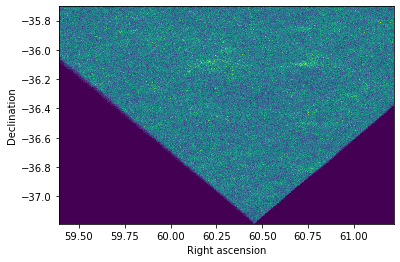

In [13]:
plt.hist2d(merged_galaxies.ra, merged_galaxies.dec, bins=500)
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.show()

The diagonal boundaries correspond to the diamond shapes that Healpixels make in RA vs. Dec space.

For convenience, specify a "square" window in RA and Dec that is fully populated by galaxies:

In [14]:
dec_lo = -36.6
dec_hi = -35.7
ra_lo = 60.0
ra_hi = 61.0

In [15]:
filters = merged_galaxies.dec > dec_lo
filters &= merged_galaxies.dec < dec_hi
filters &= merged_galaxies.ra > ra_lo
filters &= merged_galaxies.ra < ra_hi
window = merged_galaxies[filters]

See what this window looks like in RA vs. Dec:

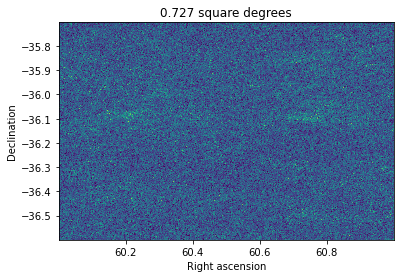

In [16]:
plt.hist2d(window.ra, window.dec, bins=500)
s = lambda deg : (180./np.pi) * np.sin(deg * np.pi/180.)
size = (ra_hi - ra_lo) * (s(dec_hi) - s(dec_lo))
plt.title(f'{size:.3f} square degrees')
plt.xlabel('Right ascension')
plt.ylabel('Declination')
plt.show()

Store the window in parquet format.

In [17]:
window.to_parquet('window.parquet')